<a href="https://colab.research.google.com/github/wiendewani/Praktikum_ML/blob/main/FInal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [1]:
!pip install imutils

In [2]:
dataset_path='/content/drive/MyDrive/Pembelajaran Mesin/Project ML/data/data/'

In [3]:
INIT_LR = 1e-4
EPOCHS = 100
BS = 32
imagePaths = list(paths.list_images(dataset_path))

In [4]:
data = []
labels = []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(label)
data = np.array(data, dtype="float32")
labels = np.array(labels)
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [8]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [6]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

In [12]:
import tensorflow as tf

In [13]:
class myCallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs={}) :
        if(logs.get('acc') is not None and logs.get('val_acc') >= 0.87) :
            print('\nReached 95 % accuracy so cancelling training!')
            self.model.stop_training = True


callbacks = myCallbacks()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
81/81 [==============================] - 108s 1s/step - loss: 0.6861 - accuracy: 0.6507 - val_loss: 0.5407 - val_accuracy: 0.7604
Epoch 2/100
81/81 [==============================] - 101s 1s/step - loss: 0.5474 - accuracy: 0.7565 - val_loss: 0.4855 - val_accuracy: 0.7972
Epoch 3/100
81/81 [==============================] - 104s 1s/step - loss: 0.4989 - accuracy: 0.7841 - val_loss: 0.4588 - val_accuracy: 0.7957
Epoch 4/100
81/81 [==============================] - 103s 1s/step - loss: 0.4778 - accuracy: 0.7974 - val_loss: 0.4425 - val_accuracy: 0.8157
Epoch 5/100
81/81 [==============================] - 103s 1s/step - loss: 0.4599 - accuracy: 0.8106 - val_loss: 0.4329 - val_accuracy: 0.8187
Epoch 6/100
81/81 [==============================] - 103s 1s/step - loss: 0.4476 - accuracy: 0.7989 - val_loss: 0.4250 - val_accuracy: 0.8203
Epoch 7/100
81/81 [==============================] - 103s 1s/step - loss: 0.4340 - accuracy: 0.8168 - val_loss: 0.4185 - val_accuracy: 0.8249
Epoch 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


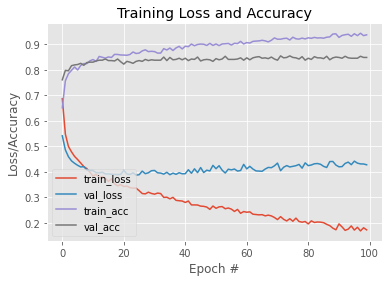

In [14]:
for layer in baseModel.layers:
    layer.trainable = False
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS, callbacks = callbacks)

predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

model.save("data.h5")
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('ploy.jpg')